In [1]:
from matplotlib import pyplot as plt
import numpy as np
from common_util import NogamiUTSData,setup_axis_default,get_k_most_commmon_feature_transform,hdi
from matplotlib import rc
import warnings
from typing import List, Tuple

#ignore warnings and set preference for matplotlib styles
warnings.filterwarnings("ignore")
rc('font',**{'family':'serif','serif':['Times'],'weight': 'bold'})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#load data
nogami_data = NogamiUTSData()

### Modeling Ultimate Tensile Strength as a Function of Temperature

Typically in engineering calculations, a polynomial state model of temperature is used to estimate macroscopic material models. This approach is entirely empirical, but is typically satisfactory as the functions are simple provided complicated physical phenomena such as phase change do not occur. In contrast, the effect of alloying or material processing on the material property is extradinarily hard to predict using first principles arguments, and experimental data is always required. It is therefore advisable to fit the emperical state model to data for a _specific_ tungsten (W) alloy, rather than an aggregate as the relationship between macroscopic material properties in two different materials is an actively researched area. 


In this notebook our goals are: 

1. Demonstrate the _spread_ (_i.e._ variation) in ultimate tensile strength (UTS) across tungsten (W) alloys, as a function of temperature. 
    1. Ensure that basic linear regression assumptions are met so that estimates in the variability are meaningful.
2. Estimate an empirical model for UTS of a specific W alloy using conventional regression analysis and design application informed model structure (detailed below)


### Feature Selection

We'd like to find a function that, once fitted, represents the ultimate tensile strength (UTS) of any particular tungten (W) alloy well. Because data tends to be fairly limited, we'd like to emphasize model parsimony during feature selection. 

It is impossible given the present data to fit a function that also interpolates across alloys. The below block fits a seperature function of UTS vs. temperature for each alloy, and uses an automated feature selection process (both BIC and CV) to determine the best features given the basis:

$
\{1, x, x^2, \ln{x}, x\ln{x},x^2 \ln{x},\frac{1}{x},\sqrt{x} \}
$

Here $x$ is the temperature (in celcius), scaled so that the data lies in $[1,2]$. The below block finds that on average, the basis:

$
\{1, \frac{1}{x}, x \ln{x}, x^2 \ln{x} \}
$

is a good choice. The cutt-off here is rather arbitrary, but four regressors leads to reasonable representations as we'll see below.

In [2]:
data= [nogami_data[key] for key in nogami_data.keys()]
feature_transform = get_k_most_commmon_feature_transform(data,3)
print(f'selected features: {str(feature_transform)}')

data_transform = feature_transform.make_sklearn_transform()


selected features: ['1', '1/x', 'x^2 log x', 'x log x']


### Model Visualization

Now that we have some features we like, lets encode this into a permanent transformation, and perform some model assessment. The below figures plot the fitted functions with the data used to fit them for alloys that are less deformed on the left, and highly deformed during processing on the right. Visual inspection indicates that the model fit is pretty good.

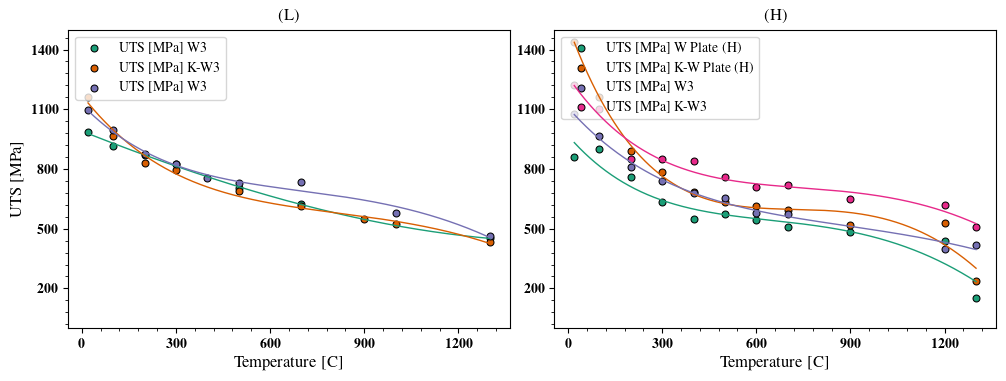

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
 
fig,axes = plt.subplots(figsize = (10,3.75),ncols = 2)

for ax,rolling in zip(axes.ravel(),['L','H']):
    setup_axis_default(ax)
    ax.set_title(f'({rolling})')
    columns = [col for col in  nogami_data.keys() if '(' + rolling + ')' in col]
    for i,column in enumerate(columns):
        color = i/len(nogami_data.keys())
        x,y = nogami_data[column]
        xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

        pipe = Pipeline([('transform',data_transform),
                         ('model',LinearRegression(fit_intercept= False))])

        pipe.fit(x,y)
        y_pred = pipe.predict(xp)
        ax.plot(xp,y_pred,lw = 1.,zorder = 100,
                color = plt.get_cmap('Dark2')(color))

        ax.scatter(*nogami_data[column],s = 25,edgecolor = 'k',
                lw = 0.75,facecolor = plt.get_cmap('Dark2')(color),label = column)


    ax.set_ylim([0,1500])
    ax.set_xlabel('Temperature [C]',fontsize = 12)
    ax.legend(loc = 'upper left',fontsize = 10)


axes[0].set_ylabel('UTS [MPa]',fontsize = 12)

fig.tight_layout(pad = 0.5) 

### Residual Analysis

In addition to examining the model fits visually, we can also perform some residual analysis. Under the linear regressive model:

$$
\mathbf{y} = \mathbf{X} \beta + \xi \\ 
\xi \sim \mathcal{N}(\mathbf{0},\sigma^2 \mathbf{I}) \\ 
 \ \mathbf{X} = [\mathbf{1},\frac{1}{\mathbf{x}},\mathbf{x} \ln{\mathbf{x}},\mathbf{x}^2 \ln{\mathbf{x}}], \beta \in \mathbb{R}^4 \\ 
$$

We can ensure that at least $\hat{\xi} = \mathbf{y} - \hat{\mathbf{y}}$ appears approximately normal ($\hat{\mathbf{y}} = \mathbf{X} \hat{\beta}$, $\hat{\beta}$ is the OLS estimate of $\beta$). If they don't, this means that our model assumptions, namely the distribution of the model error, is incorrect, and thus infernence using the fitted model may be flawed.

A good tool to check these modeling assumptions with are the so-called "externally studentized residuals" defined as:

$$
\hat{\xi}_t = \frac{\hat{\xi}}{\sqrt{S^2_i (\mathbf{I} - \text{diag}(\mathbf{H}))}} \\ 
S^2 = \frac{(n-p)S^2 \mathbf{I} - \hat{\xi}^2/(\mathbf{I} - \text{diag}(\mathbf{H}))}{n - p - 1}
$$

which are distributed $\mathcal{N}(\mathbf{0},\mathbf{I})$ if $\xi \sim \mathcal{N}(\mathbf{0},\sigma^2 \mathbf{I})$. Here $S^2$ is the unbiased estiamte of the model variance, and $\mathbf{H} = \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$ is the "hat matrix". 

We plot these studnetized residuals on a qq-plot, that is, the observed $\hat{\xi}_t$ against the theoretical quantiles from a standard normal distribution. If the residuals follow a normal distiribution, we would expect them to create a straight line on this scatter. If they are not straight, we should further inspect the validity of the chosen model. If $|\hat{\xi}_{t,i}| > 3$ the point corresonding to the residual may be an outlier.

The residuals aren't terrible below, though it appears (1) there may be an outlier for K-W (H),(2) an outlier for K-W 3\%Re (H) and (3) an outlier or two for W 3\%Re 1\% $\text{La}_2\text{O} _3$. We can try to remove these problem estimates and refit the models.

Also shown is a plot of $\hat{y}$ vs. the studentized residuals. There's not really any discenerable patterns here that is consistent across alloys, likely because there isn't enough data.

Finally, just to get an idea of the most influential points, I've also put some "Cook's Distance" and "DFFITS" plots in as well. A few extra points per data set are selected in addition to the potential outliers, however theres not really enough data to just straightforwardly eliminate these potential issue points. I'll keep them in mind as we move on to seeing the impact of removing various points that could be outliers.

UTS [MPa] W Plate (H) possible outliers:
	index: [10]
	studentized residuals: [-3.18636342]

--------------------------------------------


UTS [MPa] K-W Plate (H) possible outliers:
	index: [ 9 10]
	studentized residuals: [ 6.29984777 -3.72637964]

--------------------------------------------


UTS [MPa] W3%Re Plate (H) possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


UTS [MPa] K-W3%Re Plate (H) possible outliers:
	index: [2]
	studentized residuals: [-3.49755732]

--------------------------------------------


UTS [MPa] W3%Re Plate (L) possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


UTS [MPa] K-W3%Re Plate (L) possible outliers:
	index: [0]
	studentized residuals: [3.39644223]

--------------------------------------------


UTS [MPa] W3%Re-1%La2O3 Plate (L) possible outliers:
	index: [6 7]
	studentized residuals: [ 4.94422785 -3.17083094]

----------------------------------

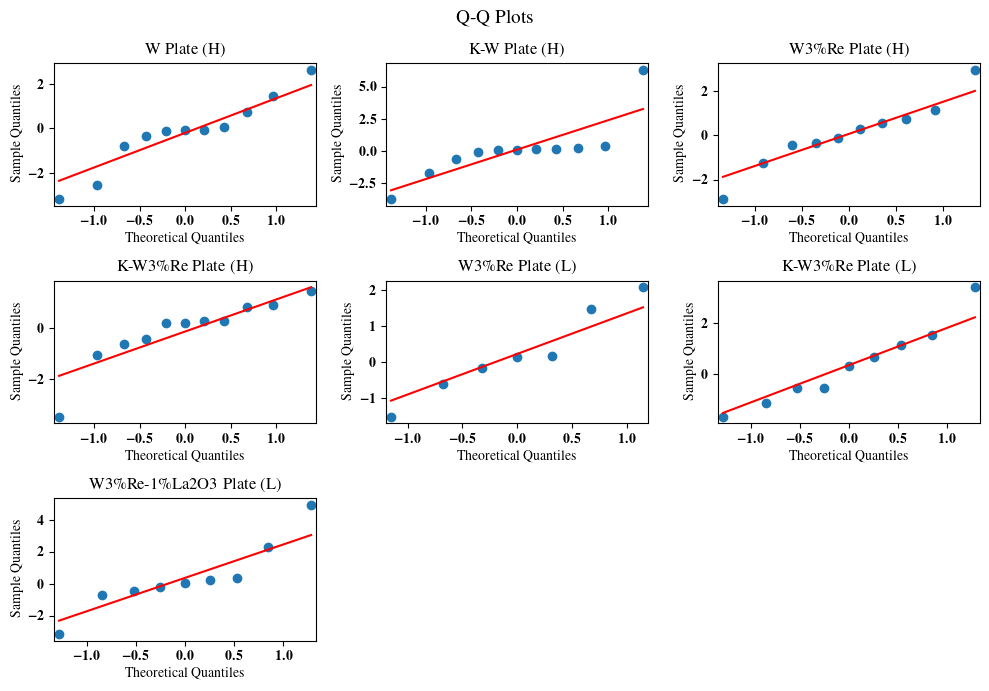

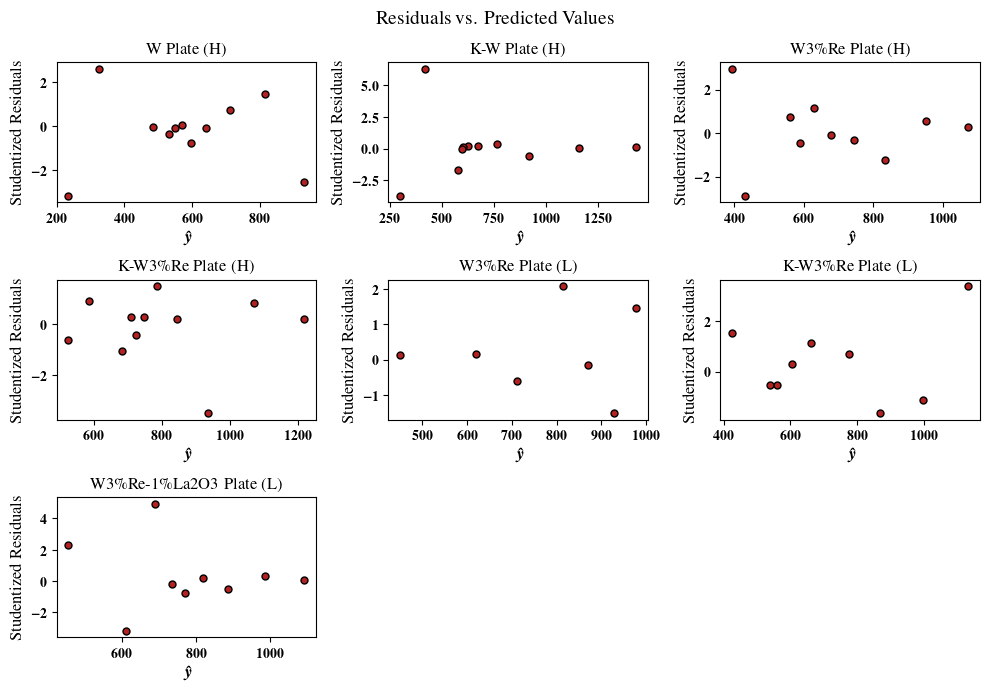

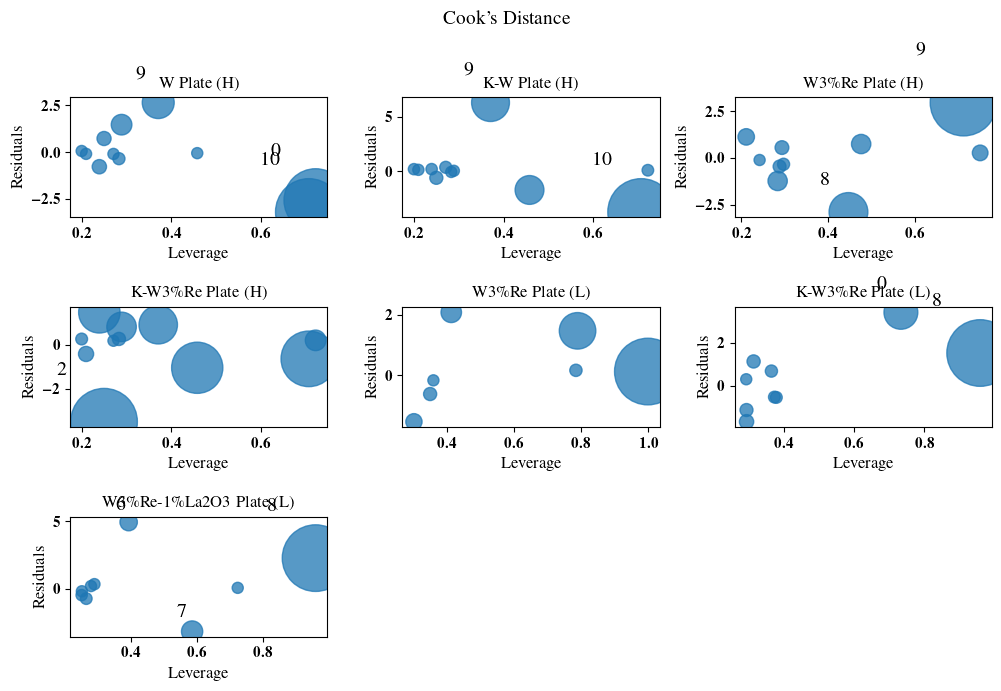

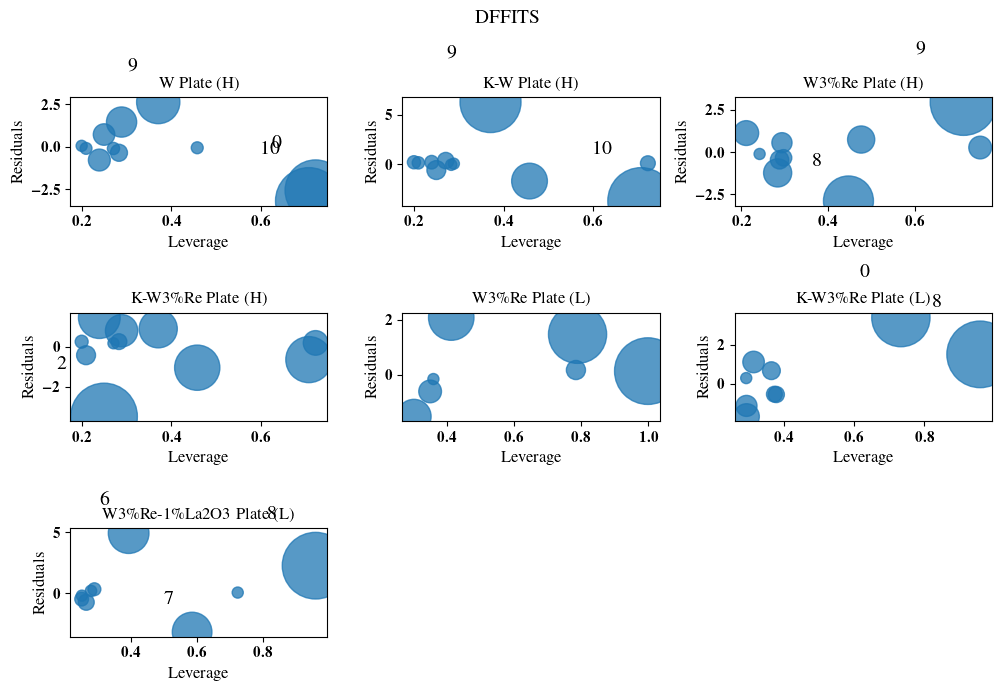

In [36]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.regressionplots import influence_plot
from statsmodels.regression.linear_model import OLS as sm_OLS
import scipy

fig,axes = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig2,axes2 = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig3,axes3 = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig4,axes4 = plt.subplots(figsize = (10,7),nrows = 3,ncols = 3)
fig.suptitle('Q-Q Plots',fontsize = 14)
fig2.suptitle('Residuals vs. Predicted Values',fontsize = 14)
fig3.suptitle('Cook\'s Distance',fontsize = 14)
fig4.suptitle('DFFITS',fontsize = 14)

for column,ax,ax2,ax3,ax4 in zip(nogami_data.keys(),axes.ravel(),axes2.ravel(),axes3.ravel(),axes4.ravel()):
    label = column[10:].replace('%','\%')
    for a in [ax,ax2]:
        a.set_title(label)

    x,y = nogami_data[column]
    xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

    #make model-data transform pipeline
    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    
    #post-porcessing to get diagnostic information
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)

    #somewhat annoying, but we need to refit the model to work with statsmodels
    #diagnostic plots. I don't want to code these up myself, so I'll just do it
    sm_ols_res = sm_OLS(y,X).fit()

    #influence plots - cooks distance
    influence_plot(sm_ols_res,ax = ax3,criterion = 'cooks')

    #influence plots - DFFITS
    influence_plot(sm_ols_res,ax = ax4,criterion = 'dffits')

    #really annoying that I can't seem to modify this with keyword arguments to "influence_plot"
    for a in [ax3,ax4]:
        a.set_xlabel('Leverage',fontsize = 12)
        a.set_ylabel('Residuals',fontsize = 12)
        a.tick_params('both',labelsize = 11)
        a.set_title(label,fontsize = 12)

    #potential outliers
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T         
    S2 = np.sum(resid**2)/(n - p)
    S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
    studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
    
    #print informatoin about potential misfits of data for each data set
    possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 3]
    
    print(f'{column} possible outliers:')
    print(f'\tindex: {possible_outliers}')
    print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

    print('\n--------------------------------------------\n\n')
    
    #plot residuals against predicted values and qqplots
    qqplot(studentized_residuals,ax = ax,line = 's',
           color = 'blue')
    ax2.scatter(H @ y,studentized_residuals,edgecolor = 'k',
                facecolor = 'firebrick',s = 25)
    ax2.set_ylabel('Studentized Residuals',fontsize = 12)
    ax2.set_xlabel('$\hat{y}$',fontsize = 12)


for ax in [axes,axes2,axes3,axes4]:
    ax[-1,-1].axis('off')
    ax[-1,-2].axis('off') 

for f in [fig,fig2,fig3,fig4]:
    f.tight_layout()


### Removing Potential Outliers and Re-Fitting the Model

Let's try removing the data points with really large externally studentized residuals and refitting the models to see how the data fits. For the application, we are going to really prioritize data at high temperatures, even if we suspect that the data isn't great, so UTS at 1300 C we'll keep no matter what it's apparent effect on the model fit. The only expception to the rule is for pure W as the authors report this data point is measured after the material has undergone a phase change known as recrystillization.

This is a somewhat iterative procedure, as removing one data point that is a potential outlier can reveal other outliers whos effect on the fit was masked. In addition, the leverage plots can help inform which points we might look at to improve the fit. The removed data points are shown below, along with the qq-plots. Overall, it seems the modeling assumptions are much better with these removed data points.

Alloy: UTS [MPa] W Plate (H) | Data Length: 9
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UTS [MPa] K-W Plate (H) | Data Length: 8
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UTS [MPa] W3%Re Plate (H) | Data Length: 9
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UTS [MPa] K-W3%Re Plate (H) | Data Length: 10
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UTS [MPa] W3%Re Plate (L) | Data Length: 7
possible leverage points: []
possible outliers:
	index: []
	studentized residuals: []

--------------------------------------------


Alloy: UTS [MPa] K-W3%Re Plate (L) | Data Length: 7
possible leverage points: []
po

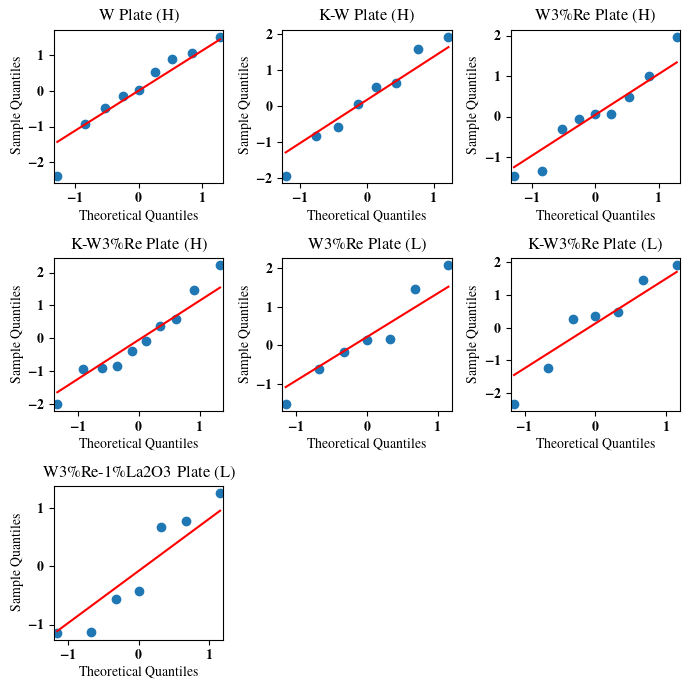

In [31]:
from statsmodels.graphics.gofplots import qqplot
import scipy

def clean_data(x: np.ndarray,y: np.ndarray,remove_points: List[int]):
    mask = np.ones_like(x.squeeze(),dtype = bool)
    mask[remove_points] = False
    return x[mask],y[mask]

fig,axes = plt.subplots(figsize = (7,7),nrows = 3,ncols = 3)


remove_data = {'UTS [MPa] W Plate (H)': [0,10],
                'UTS [MPa] K-W Plate (H)': [2,8,9],
               'UTS [MPa] K-W3%Re Plate (H)': [2],
               'UTS [MPa] W3%Re Plate (H)': [8],
                'UTS [MPa] K-W3%Re Plate (L)': [0,2],
                'UTS [MPa] W3%Re-1%La2O3 Plate (L)': [6,7]}

for column,ax in zip(nogami_data.keys(),axes.ravel()):
    label = column[10:].replace('%','\%')
    ax.set_title(label)
    x,y = nogami_data[column]
    if column in remove_data:
        x,y = clean_data(x,y,remove_data[column])
                         
    xp = np.linspace(x.min(),x.max(),1000)[:,np.newaxis]

    pipe = Pipeline([('transform',data_transform),
                        ('model',LinearRegression(fit_intercept= False))])

    pipe.fit(x,y)
    resid = y - pipe.predict(x)
    X = pipe.named_steps['transform'].transform(x)
    n,p = X.shape
    H = X @ scipy.linalg.pinvh(X.T @ X) @ X.T
                                                                                 
    S2 = np.sum(resid**2)/(n - p)
    S2_i = (n - p)/(n- p - 1)*S2 - 1/(n-p -1)*resid**2/(1 - np.diag(H))
    studentized_residuals = resid/np.sqrt(S2_i*(1 - np.diag(H)))
    leverage = np.diag(H)
    leverage_points = leverage > 2*(X.shape[1] + 1)/X.shape[0]
    print(f'Alloy: {column} | Data Length: {n}')
    print(f'possible leverage points: {np.arange(0,X.shape[0])[leverage_points]}')
    possible_outliers = np.arange(X.shape[0])[np.abs(studentized_residuals) > 3]
    print('possible outliers:')
    print(f'\tindex: {possible_outliers}')
    print(f'\tstudentized residuals: {studentized_residuals[possible_outliers]}')

    print('\n--------------------------------------------\n\n')
    qqplot(studentized_residuals,ax = ax,line = 's',
           color = 'blue')


axes[-1,-1].axis('off')
axes[-1,-2].axis('off') 
fig.tight_layout()


### Re-checking Features

Now that we've elimated some data from the models, let's make sure the features we've selected are the right ones. It seems like the still are below.

In [32]:
data= [clean_data(*nogami_data[key], remove_data[key]) if key in remove_data 
       else nogami_data[key] for key in nogami_data.keys()]

feature_transform = get_k_most_commmon_feature_transform(data,3)
print(str(feature_transform))


['1', '1/x', 'x log x', 'x^2 log x']


### Variability Across Alloys

We can now fit the OLS model on the transformed feature set for each alloy. We'll then sample the predictive distribution, as our errors are roughly normal, so we know what the predictive distribution is. We can then combine these samples to get upper and lower confidence bounds on the UTS as a function of temperature. 

In [40]:
import pickle

def sample_linear_predictive(Xnew: np.ndarray,
                             XtX_inv: np.ndarray,
                             dof: int,
                             S2: float,
                             n: int) -> Tuple[np.ndarray,np.ndarray]:

    return S2**0.5*np.sqrt(1. +  np.sum(Xnew.T*(XtX_inv @ Xnew.T),axis = 0))[:,np.newaxis]*scipy.stats.t.rvs(dof,size = (1,n))

xnew= np.linspace(20,1300,100)[:,np.newaxis]
posterior_samples = []
alloy_uts = dict.fromkeys(nogami_data.keys())

for column in nogami_data.keys():
    if column in remove_data:
        x,y = clean_data(*nogami_data[column], remove_data[column])
    else:
        x,y = nogami_data[column]
    
    pipe = Pipeline([('transform',data_transform),
                     ('model',LinearRegression(fit_intercept= False))])
    pipe.fit(x,y)

    with open(f'.model/{column}_uts.pkl','wb') as f:
        pickle.dump(pipe,f)

    resid = pipe.predict(x) - y
    
    X = pipe.named_steps['transform'].transform(x)
    Xp = pipe.named_steps['transform'].transform(xnew)

    S2 = np.sum(resid**2)/(X.shape[0] - X.shape[1])
    
    xtX_inv = scipy.linalg.pinvh(X.T @ X)
    yhat  = pipe.predict(xnew)
    alloy_uts[column]  = yhat.copy()
    posterior_samples.append(
        yhat[:,np.newaxis] + sample_linear_predictive(Xp,xtX_inv,X.shape[0] - X.shape[1],S2,2000)
    )

    print(f'{column}: R2: {round(pipe.score(x,y),4)} | std. dev.: {round(S2**0.5,2)}')

posterior_samples = np.concatenate(posterior_samples,axis = 1)

with open('.scratch/uts_posterior_samples.pkl','wb') as f:
    pickle.dump((xnew,posterior_samples),f)

low_uts,high_uts = hdi(posterior_samples,0.95).T

mean_uts = np.mean(posterior_samples,axis = 1)



UTS [MPa] W Plate (H): R2: 0.982 | std. dev.: 24.84
UTS [MPa] K-W Plate (H): R2: 0.9999 | std. dev.: 3.95
UTS [MPa] W3%Re Plate (H): R2: 0.9961 | std. dev.: 16.16
UTS [MPa] K-W3%Re Plate (H): R2: 0.9894 | std. dev.: 27.58
UTS [MPa] W3%Re Plate (L): R2: 0.9979 | std. dev.: 11.99
UTS [MPa] K-W3%Re Plate (L): R2: 0.9998 | std. dev.: 3.62
UTS [MPa] W3%Re-1%La2O3 Plate (L): R2: 0.9983 | std. dev.: 11.8


### Visualizing Important UTS Functions.

For future analysis, we'd like to select specific curves of interest that have intrinsic meaning. To that end, there are four ultimate tensile strength functions we care about: 

1. The expected value of the K-W3\%Re Plate (L) alloy.
2. The expected value of the K-W3\%Re Plate (H) alloy. 
3. The overall expected value across all alloys. 
4. A lower confidence interval. 

We care about the first two, because these are candidate alloys. We're not too worried about taking the conservative interval on these, because fusion reactor conditions will effect these values in unpredictable ways, and a mean is representative enough. The overall expected value across all alloys is valuable as representing an average for any particular alloy, and the lower confidence interval serves as a pessimistic bound on the expected performance of any alloy. 

Interestingly, the predicted value for the K-W3\%Re Plate (L) alloy and the overall mean essentially coincide. This has the useful interpretation of the  K-W3\%Re Plate (L) essentially being an "average" alloy.

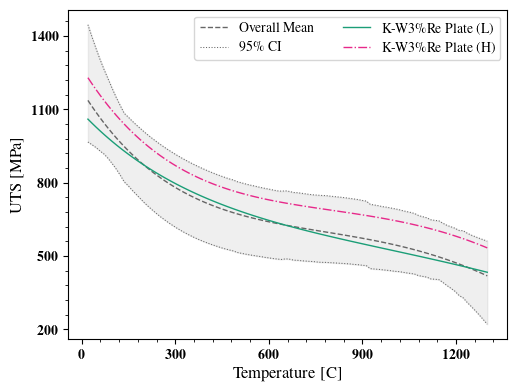

In [38]:
fig,ax = plt.subplots(figsize = (5,3.75))
setup_axis_default(ax)
ax.set_xlabel('Temperature [C]',fontsize = 12)
ax.set_ylabel('UTS [MPa]',fontsize = 12)

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,mean_uts,lw = 1.,zorder = 100,color = sum_color,ls = '--',label = 'Overall Mean')
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = '95\% CI') 
ax.plot(xnew,high_uts,lw = 0.75,color  = sum_color,ls = ':')
ax.fill_between(xnew[:,0],low_uts,high_uts,color = sum_color,alpha = 0.1)

labels = {'UTS [MPa] K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'UTS [MPa] K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_uts[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

ax.legend(fontsize = 10,ncols = 2)  
fig.tight_layout(pad = 0.1)


### Final Visualizations over the Data

Finally, let's visualize these three functions over the whole gathered dataset of UTS. I'll omit showing the "overall mean" now that we understand this is well represented by the expected value of the K-W3\%Re Plate (L) alloy. 

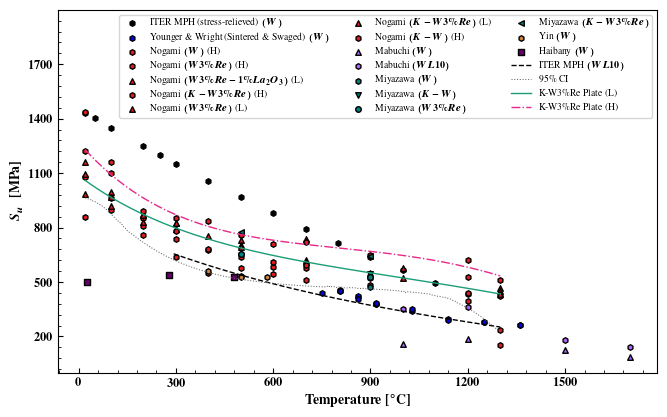

In [35]:
import pickle

with open('.scratch/uts_data_fig.pkl','rb') as f:
    data = pickle.load(f)
    fig,ax = data

sum_color = plt.get_cmap('Dark2')(0.9)
ax.plot(xnew,low_uts,lw = 0.75,color  = sum_color,ls = ':',label = '95\% CI') 

labels = {'UTS [MPa] K-W3%Re Plate (L)':'K-W3\%Re Plate (L)',
          'UTS [MPa] K-W3%Re Plate (H)': 'K-W3\%Re Plate (H)'}

for alloy,color,ls in zip(labels,plt.get_cmap('Dark2')([0.1,0.4]),['-','-.']):
    ax.plot(xnew,alloy_uts[alloy],lw = 1.,zorder = 100,color = color,
            label = labels[alloy],ls = ls)

ax.legend(fontsize = 7,ncols = 3)  
fig.tight_layout(pad = 0.1)
fig.savefig('images/uts_data_fit.svg')